In [11]:
import h5py
import numpy as np
import george
import corner
import matplotlib.pyplot as plt
% matplotlib inline

import sys
sys.path.insert(0, '../code/')

#import plotting

In [12]:
filename = "../data/paper_plots/221/ztf-lsst/221_lc_49627_to_49787.txt_sampled_ztf-lsst_10days.txt.hdf5"

In [2]:
filename = "../data/hdf5_testing/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days_take2.txt.hdf5"

In [13]:
def set_kernel(time, flux, flux_err):
    ###kernel###   
    # set up the gp kernel again
    #(because it can't be saved to hdf5 file)
    mean_flux = np.mean(flux)
    log_amp = np.log(flux.max()-flux.min())
    gamma = 1
    log_period = 0

    params = {"mean": mean_flux, "log_amp": log_amp, "gamma": gamma,"log_period": log_period}
    
    kernel = np.exp(params["log_amp"]) * george.kernels.ExpSine2Kernel(gamma = params["gamma"], log_period = params["log_period"])
    gp = george.GP(kernel, fit_mean=True, mean=params["mean"])
    gp.compute(time, flux_err)
    
    return gp

In [14]:
def plot_corner(data, walkers, iterations, gp):
    
    labels = list(gp.get_parameter_names())
    labels[3] = 'period hours'
    
    corner.corner(data.reshape(walkers*iterations,4), labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 10})
    #plt.savefig(namestr + "_corner.pdf", format="pdf")
    
def plot_corner_5_95(data, walkers, iterations, gp):
    """Plot the 5-95th percentile of data in a corner plot."""
    
    lower, upper = np.percentile(data[:,:,3], [5,95])
    masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]
    
    labels = list(gp.get_parameter_names())
    labels[3] = 'period hours'
    labels_no_outliers = [s + " 5-95th" for s in labels]

    corner.corner(masked_data, labels=labels_no_outliers, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 10})
      #  plt.savefig(namestr + "_corner.pdf", format="pdf")
        
def plot_posterior(data, true_period):
    ###posterior distribution
    
    fig, (ax, bx, cx) = plt.subplots(1, 3, figsize=(15,4))
    flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    
    ax.hist(flat_data[:,3], bins='auto', density=True, color="black",alpha=0.5)

    

    
    if true_period != 0:
        ylim = ax.get_ylim()
        ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

    ax.set_xlabel("Period in hours")
    ax.set_ylabel("Probability")
    ax.set_title("Posteriod Period Distibution")
    ax.legend()

    lower, upper = np.percentile(data[:,:,3], [5,95])
    masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]
    
    #lower, upper = np.percentile(p_hours, [5,95])
    n, bins, patches = bx.hist(masked_data[:,3], bins='auto', density=True,  label="posterior PDF", alpha=0.5)
    
    if true_period != 0:
        ylim = bx.get_ylim()
        bx.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

    bx.set_title("5th - 95th Percentile")
    bx.set_xlabel("Period in hours")
    bx.set_ylabel("Probability")
    bx.legend()


    idx = n.argmax()
    edges = bins[idx : idx+2]
    
    ###calculating confidence values
    confidence = n.max()/n.sum() 
    area = (edges[1]-edges[0])/(bins[-1] - bins[0])#
    
    print(n.max(), n.sum())
    print(confidence)
    print(area)
    print(area*n.max())
    
    zoom_data = data[(data[:,:,3]>edges[0]) & (data[:,:,3]<edges[1])]
    best_period = np.percentile(zoom_data[:,3], 50)
    
    cx.hist(zoom_data[:,3], bins='auto', density=True)
    ylim = cx.get_ylim()
    cx.vlines(best_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="best period : %.3f" %best_period)
    cx.set_title("Confidence Interval %.3f" %confidence)
    cx.set_xlabel("Period in hours")
    cx.set_ylabel("Probability")
    cx.legend()

    print(best_period)   
    

    #plt.tight_layout()
    #plt.savefig(namestr + "_period_pdf.pdf", format="pdf")
    
    return best_period
    
def plot_trace(data, iterations):
    dims = ['mean', 'log_amp', 'gamma', 'period']
    
    fig, ax = plt.subplots(2, 2, figsize=(7,6))
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    #if data_pts is not None:
    #fig.suptitle("Data points: " + str(f.attrs['data_pts']) + "\nMean acceptance fraction:{0:.3f}".format(np.mean(f.attrs['acceptance_faction'])))

    #else:
    #    fig.suptitle("Mean acceptance fraction: 0:.3f}".format(np.mean(f.attrs['acceptance_fraction'])))


    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    x = np.arange(iterations)

    for i in range(data.shape[2]):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(data.shape[0]):
            param = data[j,:,i]
            axs[i].plot(x, param, 'k-', alpha=0.3)

def run_lsp(time, flux, flux_err, data, true_period):
    """Determines the Lomb-Scargle Periodogram for nterms 1-3."""

    from scipy.signal import argrelextrema

    #get l-s best period estimate
    from lombscargle import make_lsp
    from astropy.stats import LombScargle
    
    lower, upper = np.percentile(data[:,:,3], [5,95])
    masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]

    fig, ax = plt.subplots(3,2, figsize=(10,10))
    #fig.set_tight_layout('tight')
    
    #axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0], ax[2,1]]
    
    for i in np.arange(3):
        freq, power = make_lsp(time, flux, flux_err, p_max=5.0, nterms=(i+1))

        # determine the indices of local power maxima
        best_idx = argrelextrema(power, np.greater)

        # sort these indices based on actual power value
        # reverse list so max is read first
        indices = np.argsort(power[best_idx[0]])[::-1]

        # sort our original indices based on the new
        # power-sorted indices
        best_idx = (best_idx[0]).T[indices]
        best_freqs = freq[best_idx].T

        new_freq = best_freqs[0]
        new_period = 1./new_freq
        new_log_period = np.log(1./new_freq)

        #self.true_period = true_period
        #self.lsp_period = new_period*24.

        # plot all the frequencies
        
        ax[i][0].plot((1./freq)*24., power, color="black", alpha=0.7)
        ax[i][0].set_xlabel('Period (hrs)')
        ax[i][0].set_ylabel("Normalized Power")
        ax[i][0].set_title("nterms = %s" %(i+1))
        ax[i][0].vlines(new_period*24., 0, 1, colors='orange', linestyles='--',
                  label = 'Best fit : ' + str(round(new_period*24., 5)))
        if true_period != 0:
            ax[i][0].vlines(true_period, 0, 1, colors='blue', linestyles='--',
                  label = 'True fit : ' + str(true_period))
        ax[i][0].hist(masked_data[:,3], bins=50, alpha=0.5, density=True, label="Posterior")
        ax[i][0].set_xlim([0,24])
        ax[i][0].set_ylim(ymin=0)
        ax[i][0].legend()
        
        if true_period:
            ax[i][0].vlines(true_period, 0, 1, colors='blue', linestyles='--',
                            label = 'True fit : ' + str(true_period))

        plot_folded_lightcurve(time, flux, period=new_period, ax=ax[i][1])
        print(new_period)

    #namestr=filename + "_plots"
    plt.tight_layout()
    #plt.savefig(namestr + "_lsp.pdf", format="pdf")

    return



In [15]:
def plot_folded_lightcurve(time, flux, period, flux_err=None, models=None, true_lightcurve=None,
                      ax=None, use_radians=False, legend=True, colours=None):
    """
    Plot a folded periodic light curve, potentially including the true underlying
    model that produced the data (in the case of simulations), or model
    light curves from MCMC.

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    period : float
        The period on which to fold **in days**

    models : iterable of shape (model_time, numpy.ndarray of shape (nsamples, len(model_time)))
        First element here contains the time stamps for the models (which may not be the same
        as for the data), the second is an array of shape (nsamples, ndatapoints), where nsamples
        is the number of model light curves, and ndatapoints == len(model_time)

    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the
        simulated data was created (could be higher-resolution than the "data"), useful for
        comparison between models created e.g. from MCMC samples and the true underlying process


    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a
        new figure.

    use_radians : bool, default False
        If True, the phase will be plotted from (0, 2pi) instead of (0,1), which is the default.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """

    if colours is None:
        colours = ["black", "#33B3FF", "#FFB733"]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))

    t0 = np.min(time)
    if models:
        t0 = np.min([t0, np.min(models[0])])

    if true_lightcurve:
        t0 = np.min([t0, np.min(true_lightcurve[0])])

    phase = (time-t0)/period - np.floor((time-t0)/period)

    if use_radians:
        phase *= 2.*np.pi

    if flux_err is None:
        ax.scatter(phase, flux, s=5, color=colours[0], label="data")
    else:
        ax.errorbar(phase, flux, yerr=flux_err, fmt="o", c=colours[0], markersize=5, label="data")

    if true_lightcurve:
        true_time = (true_lightcurve[0] - t0)
        true_flux = true_lightcurve[1]
        true_phase = true_time/period - np.floor(true_time/period)

        if use_radians:
            true_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(true_phase)
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]

        # loop through indices where phase goes from 1 (or 2pi) to 0
        # plot each phase light curve separately
        istart = 0
        iend = idx[0]+1

        # first phase cycle also contains the label for the legend
        ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3,
                c=colours[1], label="true light curve")

        for i, x in enumerate(idx[:-1]):
            ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3, c=colours[1])
            istart = x+1
            iend = idx[i+1]+1

        # last plot
        istart = idx[-1]+1
        ax.plot(true_phase[istart:], true_flux[istart:], alpha=0.3, c=colours[1])

    if models:

        m_time = (models[0] - t0)
        m_flux = models[1]

        m_phase = (m_time/period) - np.floor(m_time/period)
        print("mphase " + str(m_phase))
        if use_radians:
            m_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(m_phase)

        print("tdiff " + str(tdiff))
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]
        #if idx.size == 0:
        #    idx = np.array(0)

        # loop through the different samples
        for i,m in enumerate(m_flux):
            # loop through indices where phase goes from 1 (or 2pi) to 0
            # plot each phase light curve separately
            istart = 0
            iend = idx[0]+1

            if i == 0:
                # first phase cycle also contains the label for the legend
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="model")

            else:
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2])

            for j, x in enumerate(idx[:-1]):
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2])

                istart = x+1
                iend = idx[j+1]+1

            # last plot
            istart = idx[-1]+1
            ax.plot(m_phase[istart:], m[istart:], alpha=0.1, c=colours[2])

    if legend:
        ax.legend()
    ax.set_xlabel("Rotational Phase")
    ax.set_ylabel("Flux")
    period_hours = period*24.
    ax.set_title(r"period $P = %.3f$"%period_hours)
    if use_radians:
        ax.set_xlim(0, 2*np.pi)
    else:
        ax.set_xlim(0, 1)
    return ax


No handles with labels found to put in legend.


(100, 300, 4)
0.7746898571350291 3.945800730191159
0.19633273703041218
0.016666666666666583
0.012911497618917087
10.436727049496547
0.05845075966307171
0.04639102794395589
0.09526253327773679


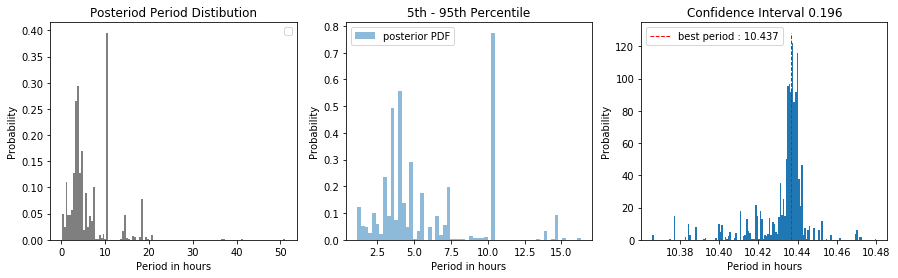

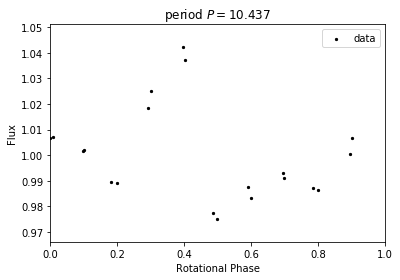

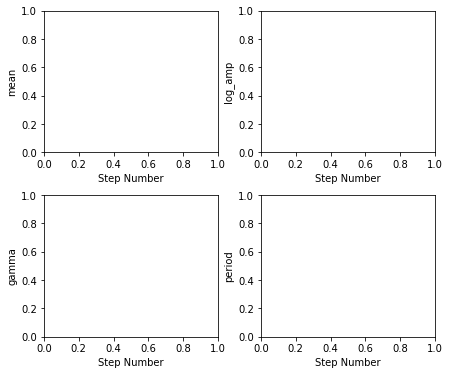

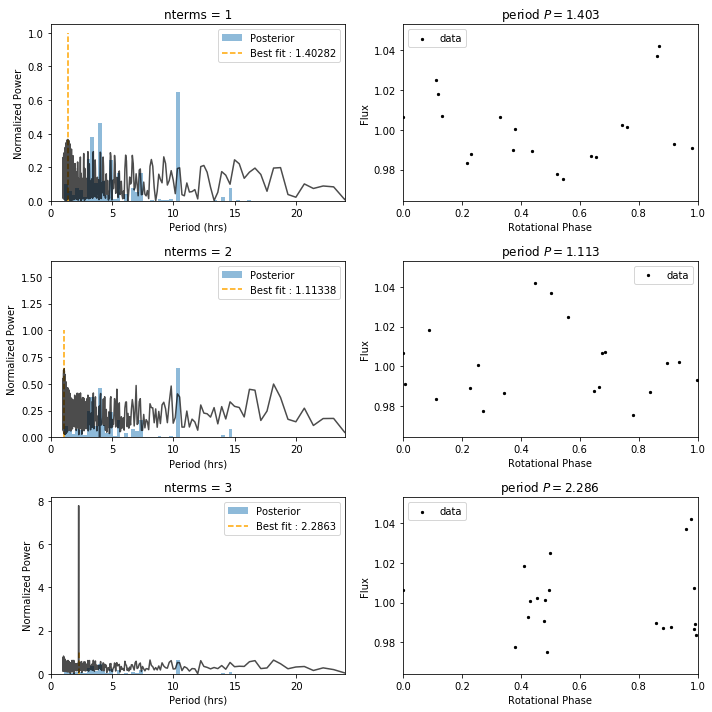

In [23]:
with h5py.File(filename, "r") as f:
    data = f['chain'][:]
    time = f['time'][:]
    flux = f["flux"][:]
    flux_err = f['flux_err'][:]
    true_period = f.attrs['true_period']
    
    print(data.shape)
    
    #for key in f.attrs.keys():
    #    print(key)
    
    
    gp = set_kernel(time, flux, flux_err)
   
    data[:,:,3] = np.exp(data[:,:,3])*24.
    
    #plot_corner(data, f.attrs['walkers'], f.attrs['iterations'], gp)
    
    #plot_corner_5_95(data, f.attrs['walkers'], f.attrs['iterations'], gp)
    
    best_period = plot_posterior(data, true_period=true_period)
    
    ##folded lightcurve###
    plot_folded_lightcurve(time, flux, period=(best_period)/24.)
    
    plot_trace(data[100:], f.attrs['iterations'])
    
    run_lsp(time, flux, flux_err, data, true_period)